# Ray Dalio's Holy Grail

Reducing return/risk ratio through diversification.

From https://www.investopedia.com/video/play/ray-dalio-his-portfolio-holy-grail/

In [1]:
%config InlineBackend.figure_format = "retina"
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

sns.set()

In [304]:
# Alternative implementation using Cholesky decomp
from scipy.linalg import cholesky

def _correlated_streams(n, risk, corr):
    # Assuming 10% average return
    mean = 10
    num_samples = 10_000

    streams = np.random.normal(loc=mean, scale=risk, size=(num_samples, n))
    
    corr_mat = np.diag(np.ones(n))
    corr_mat[0] = corr_mat[:,0] = corr
    corr_mat[0,0] = 1
    print(corr_mat)
    upper_cholesky = cholesky(corr_mat)
    
    return streams @ upper_cholesky

In [140]:
# Alternative implementation

def _correlated_sample(sample, corr):
    var = corr**2
    error_term = 1 - var
    std = np.sqrt(error_term)
    rvs = np.random.normal(loc=0, scale=std, size=len(sample))
    
    sample_mean, sample_std = sample.mean(), sample.std()
    normalized = (sample - sample_mean) / sample_std
    
    return (corr * normalized + rvs) * sample_std + sample_mean

In [141]:
# Alternative impl
def _correlated_streams(n, risk, corr):
    # Assume average anual return of %10
    benchmark = np.random.normal(loc=10, scale=risk, size=10000)
    streams = np.array([correlated_sample(benchmark, corr) for _ in range(n)])

    return (benchmark, streams)

In [243]:
def correlated_streams(n, risk, corr):
    # Assuming 10% average return
    # Benchmark avg return 10%, avg std %15
    means = np.full(n, 10, dtype=np.dtype("d"))
    bench_std = 15
    num_samples = 10_000
    
    corr_mat = np.diag(np.full(n, 9.9, dtype=np.dtype("d")))
    corr_mat += 0.1
    corr_mat = corr_mat / 10
    corr_mat[0] = corr_mat[:,0] = corr
    corr_mat[0,0] = 1
    stds = np.full(n, risk)
    stds[0] = bench_std
    stds_mat = np.diag(stds)
    cov_mat = stds_mat @ corr_mat @ stds_mat
    
    streams = np.random.multivariate_normal(means, cov_mat, size=num_samples, tol=0.01)
    
    return (streams[:,0], streams[:,1:])

In [235]:
def aggregate_risk(return_streams, n):
    """Returns the pooled risk (std) of the `n` first streams 
    in `return_streams`
    """
    aggregate_returns = np.sum(return_streams[:,:n], axis=1) / n
    return aggregate_returns.std()

In [244]:
assets = range(1, 21)
risk_levels = range(1, 15)
index = pd.MultiIndex.from_product([risk_levels, assets], names=["risk_level", "num_assets"])

simulated_data = pd.DataFrame(index=index)

for risk in risk_levels:
    for corr in np.arange(0.1, .7, 0.1):
        benchmark, return_streams = correlated_streams(max_assets, risk, corr)
        risk_level = np.zeros(max_assets)
        for num_assets in assets:
            risk_level[num_assets-1] = aggregate_risk(return_streams, num_assets)
        simulated_data.loc[(risk, ), round(corr, 1)] = risk_level
        
simulated_data.columns.names = ["correlation"]

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: covariance is not symmetric positive-semidefinite.


In [277]:
subset = simulated_data.query("risk_level == 10")
stacked = subset.stack().reset_index(name="risk")
stacked.head()

,risk_level,num_assets,correlation,risk
0,10,1,0.1,10.015191
1,10,1,0.2,9.928593
2,10,1,0.3,9.979866
3,10,1,0.4,10.432665
4,10,1,0.5,10.490940


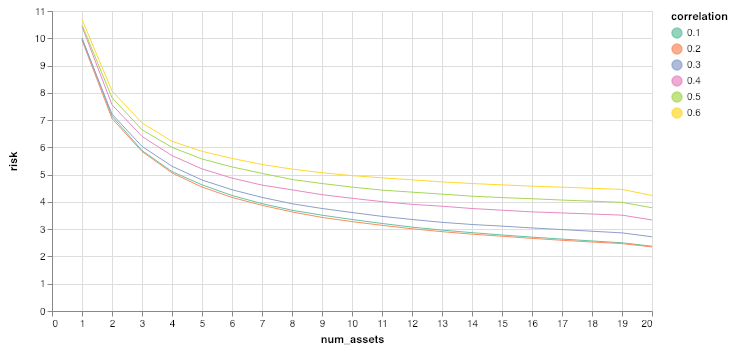

In [276]:
chart = alt.Chart(data=stacked)

highlight = alt.selection(type="single", on="mouseover",
                          fields=["correlation"], nearest=True)

base = chart.encode(
            alt.X("num_assets:Q"),
            alt.Y("risk:Q"),
            alt.Color("correlation:N", scale=alt.Scale(scheme="set2")))

points = base.mark_circle().encode(
    opacity=alt.value(0)
).add_selection(
    highlight
).properties(
    width=600
)

lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1), alt.value(3))
)

points + lines